## Problem Statement - Lending Club Case

In [ ]:
# You work for a consumer finance company which specialises in lending various types of loans to urban customers. 
# When the company receives a loan application, the company has to make a decision for loan approval based on the 
# applicant’s profile. Two types of risks are associated with the bank’s decision:

# If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company

# If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to 
# a financial loss for the company

# The data given below contains the information about past loan applicants and whether they ‘defaulted’ or not. 
# The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking 
# actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc

In [36]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To convert scientific values
pd.options.display.float_format = '{:.2f}'.format 

# Ignore warnings due to version problems
import warnings
warnings.filterwarnings('ignore')

### Data Overview & Understanding

In [38]:
# Reading CSV file

loan_data = pd.read_csv('loan.csv')

In [40]:
# identifying all null value columns

all_null_columns = loan_data.columns[loan_data.isnull().all()]
num_all_null_columns = len(all_null_columns)
print(num_all_null_columns)

# checking for duplicates

duplicate_rows = loan_data.duplicated(subset=None, keep='first').sum()
print(duplicate_rows)

54
0


In [ ]:
# Identifying columns not useful or relevant

# id, member_id  - not required
# acc_now_delinq - empty
# funded_amnt - not useful, funded_amnt_inv can be used which is funded by investors
# pymnt_plan, initial_list_status - fixed value as n & f respectively for all
# url, desc, emp_title  - not useful
# title - too many distinct values not useful
# zip_code - complete zip is not available
# mths_since_last_delinq - only half values are there, not much information
# mths_since_last_record - only 10% values are there
# revol_bal, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv - not needed for defaulter analysis
# total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee - not needed for defaulter analysis
# last_pymnt_d, last_credit_pull_d, last_pymnt_amnt, next_pymnt_d, chargeoff_within_12_mths - not needed for defaulter analysis
# collections_12_mths_ex_med, policy code, acc_now_delinq, delinq_amnt, tax_liens , application_type  - only 1 value columns
# addr_state - state level info will not aid in decision making

### Data Cleaning & Transforming

In [42]:
# dropping all null columns

loan_data = loan_data.dropna(axis=1, how="all")


In [ ]:
loan_data.shape

In [44]:
# dropping other columns based based on our analysis (explained before)

ColsToBeDropped = ["id", "member_id", "funded_amnt", "emp_title", "pymnt_plan", "url", "desc", "title", "zip_code", 
                   "mths_since_last_delinq", "mths_since_last_record", "revol_bal", "initial_list_status", "out_prncp",
                   "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", 
                   "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", 
                   "next_pymnt_d", "last_credit_pull_d", "collections_12_mths_ex_med", "policy_code", "acc_now_delinq", 
                   "chargeoff_within_12_mths", "delinq_amnt", "tax_liens", "application_type", "addr_state"]
loan_data.drop(ColsToBeDropped, axis=1, inplace=True)

In [46]:
loan_data.shape

(39717, 23)

In [48]:
# dealing with missing values

# Though emp_length column has only 2.7% missing values, the column is dependent on various factors 
# hence imputing is not a preferable option for analysis, so it is better to remove those rows

loan_data.dropna(axis=0, subset=["emp_length"], inplace=True)

# similarly revol_util is a dependent and hence removing missing values (~ 0.1% of the total)

loan_data.dropna(axis=0, subset=["revol_util"], inplace=True)

In [50]:
# To enable effective analysis, standardize some columns to formats that work well for analysis

# convert int_rate, revol_util to numeric type (removing % sign)

loan_data["int_rate"] = pd.to_numeric(loan_data["int_rate"].apply(lambda x:x.split('%')[0]))
loan_data["revol_util"] = pd.to_numeric(loan_data["revol_util"].apply(lambda x:x.split('%')[0]))

# Remove text from (loan) term column and convert it to numeric type

loan_data["term"] = pd.to_numeric(loan_data["term"].apply(lambda x:x.split()[0]))

In [52]:
# removing rows with loan status as “Current” since it is not useful to generate insights for defaulting

loan_data = loan_data[loan_data["loan_status"].apply(lambda x:False if x == "Current" else True)]


In [54]:
# modifying emp_length to remove "<" from "< 1 year" and "+" from "10+ years

loan_data["emp_length"] = pd.to_numeric(loan_data["emp_length"].apply(lambda x:0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))

In [56]:
# removing rows with less than 1% of value for any (loan) purpose

loan_purpose_info = loan_data["purpose"].value_counts()*100/loan_data.shape[0]
loan_purpose_remove = loan_purpose_info[loan_purpose_info<1].index.values
loan_data = loan_data[[False if p in loan_purpose_remove else True for p in loan_data["purpose"]]]

In [58]:
# modifying loan_status to 0 for Fully Paid and to 1 for Charged Off to aid our analysis

loan_data["loan_status"] = loan_data["loan_status"].apply(lambda x: 0 if x == "Fully Paid" else 1)

In [60]:
loan_data.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,pub_rec_bankruptcies
0,5000,4975.00,36,10.65,162.87,B,B2,10,RENT,24000.00,...,credit_card,27.65,0,Jan-85,1,3,0,83.70,9,0.00
1,2500,2500.00,60,15.27,59.83,C,C4,0,RENT,30000.00,...,car,1.00,0,Apr-99,5,3,0,9.40,4,0.00
2,2400,2400.00,36,15.96,84.33,C,C5,10,RENT,12252.00,...,small_business,8.72,0,Nov-01,2,2,0,98.50,10,0.00
3,10000,10000.00,36,13.49,339.31,C,C1,10,RENT,49200.00,...,other,20.00,0,Feb-96,1,10,0,21.00,37,0.00
5,5000,5000.00,36,7.90,156.46,A,A4,3,RENT,36000.00,...,wedding,11.20,0,Nov-04,3,9,0,28.30,12,0.00


In [62]:
print(loan_data['loan_status'].unique())

[0 1]


#### Checking & treating outliers

In [64]:
# annual income (annual_inc) before outliers treatment

loan_data['annual_inc'].describe()

count     36388.00
mean      69540.19
std       64953.76
min        4080.00
25%       41496.00
50%       60000.00
75%       83000.00
max     6000000.00
Name: annual_inc, dtype: float64

In [66]:
# treating outliers in annual_inc - Removing Outliers quantile .99 from Annual Income
# annual income after outliers treatment

annual_inc_outlier = loan_data["annual_inc"].quantile(0.99)
#loan_data = loan_data[loan_data["annual_inc"] < annual_inc_outlier]

#loan_data['annual_inc'].describe()

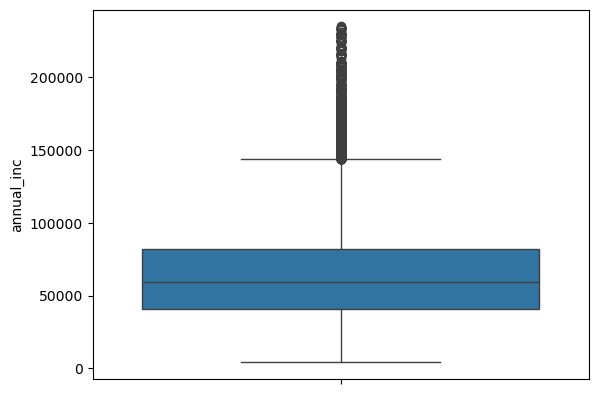

In [123]:
sns.boxplot(loan_data.annual_inc)
plt.show()

In [68]:
# open credit lines (open_acc) before outliers treatment

loan_data['open_acc'].describe()

count   36388.00
mean        9.32
std         4.39
min         2.00
25%         6.00
50%         9.00
75%        12.00
max        44.00
Name: open_acc, dtype: float64

In [70]:
# treating outliers in open_acc - Removing outliers from open credit lines
# open credit lines after outliers treatment

open_acc_outlier = loan_data["open_acc"].quantile(0.999)
loan_data = loan_data[loan_data["open_acc"] < open_acc_outlier]

loan_data['open_acc'].describe()

count   36347.00
mean        9.30
std         4.32
min         2.00
25%         6.00
50%         9.00
75%        12.00
max        29.00
Name: open_acc, dtype: float64

In [72]:
# total credit lines (total_acc) before outliers treatment

loan_data['total_acc'].describe()

count   36347.00
mean       22.11
std        11.34
min         2.00
25%        14.00
50%        20.00
75%        29.00
max        90.00
Name: total_acc, dtype: float64

In [74]:
# treating outliers in total_acc - Removing outliers from total credit lines
# total credit lines after outliers treatment

total_acc_outlier = loan_data["total_acc"].quantile(0.98)
loan_data = loan_data[loan_data["total_acc"] < total_acc_outlier]

loan_data['total_acc'].describe()

count   35536.00
mean       21.34
std        10.22
min         2.00
25%        13.00
50%        20.00
75%        28.00
max        49.00
Name: total_acc, dtype: float64

In [76]:
# records of "financial obligation not met" (pub_rec) before outliers treatment

loan_data['pub_rec'].describe()

count   35536.00
mean        0.05
std         0.24
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         4.00
Name: pub_rec, dtype: float64

In [78]:
# treating outliers in pub_rec - Removing outliers from "financial obligation not met" data
# "financial obligation not met" data after outliers treatment

pub_rec_outlier = loan_data["pub_rec"].quantile(0.995)
loan_data = loan_data[loan_data["pub_rec"] < pub_rec_outlier]

loan_data['pub_rec'].describe()

count   33671.00
mean        0.00
std         0.00
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         0.00
Name: pub_rec, dtype: float64

In [80]:
loan_data.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,pub_rec_bankruptcies
0,5000,4975.00,36,10.65,162.87,B,B2,10,RENT,24000.00,...,credit_card,27.65,0,Jan-85,1,3,0,83.70,9,0.00
1,2500,2500.00,60,15.27,59.83,C,C4,0,RENT,30000.00,...,car,1.00,0,Apr-99,5,3,0,9.40,4,0.00
2,2400,2400.00,36,15.96,84.33,C,C5,10,RENT,12252.00,...,small_business,8.72,0,Nov-01,2,2,0,98.50,10,0.00
3,10000,10000.00,36,13.49,339.31,C,C1,10,RENT,49200.00,...,other,20.00,0,Feb-96,1,10,0,21.00,37,0.00
5,5000,5000.00,36,7.90,156.46,A,A4,3,RENT,36000.00,...,wedding,11.20,0,Nov-04,3,9,0,28.30,12,0.00


#### Derived columns to aid analysis

In [82]:
# deriving year & month columns from issue date to make analysis easy

loan_data.issue_d = pd.to_datetime(loan_data.issue_d, format='%b-%y')
loan_data['year']=loan_data['issue_d'].dt.year
loan_data['month']=loan_data['issue_d'].dt.month

loan_data.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,pub_rec_bankruptcies,year,month
0,5000,4975.00,36,10.65,162.87,B,B2,10,RENT,24000.00,...,0,Jan-85,1,3,0,83.70,9,0.00,2011,12
1,2500,2500.00,60,15.27,59.83,C,C4,0,RENT,30000.00,...,0,Apr-99,5,3,0,9.40,4,0.00,2011,12
2,2400,2400.00,36,15.96,84.33,C,C5,10,RENT,12252.00,...,0,Nov-01,2,2,0,98.50,10,0.00,2011,12
3,10000,10000.00,36,13.49,339.31,C,C1,10,RENT,49200.00,...,0,Feb-96,1,10,0,21.00,37,0.00,2011,12
5,5000,5000.00,36,7.90,156.46,A,A4,3,RENT,36000.00,...,0,Nov-04,3,9,0,28.30,12,0.00,2011,12


#### Binning (grouping) continuous variable to simplify analysis

In [84]:
# creating bins for loan_amnt

bins = [0, 5000, 10000, 15000, 20000, 25000, 36000]
loan_range = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000+']
loan_data['loan_amnt_range'] = pd.cut(loan_data['loan_amnt'], bins, labels=loan_range)

In [86]:
# creatint bins for int_rate 

bins = [0, 7.5, 10, 12.5, 15, 100]
int_rate_range = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15+']
loan_data['int_range'] = pd.cut(loan_data['int_rate'], bins, labels=int_rate_range)

In [88]:
# creating bins for annual_inc

bins = [0, 25000, 50000, 75000, 100000, 1000000]
annual_inc_range = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000+']
loan_data['inc_range'] = pd.cut(loan_data['annual_inc'], bins, labels=annual_inc_range)

In [90]:
# create bins for installment

def installment(n):
    if n <= 200:
        return 'low'
    elif n > 200 and n <=500:
        return 'medium'
    elif n > 500 and n <=800:
        return 'high'
    else:
        return 'very high'
loan_data['installment'] = loan_data['installment'].apply(lambda x: installment(x))

In [92]:
# create bins for dti

bins = [-1, 5.00, 10.00, 15.00, 20.00, 25.00, 50.00]
dti_r = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+']
loan_data['dti_range'] = pd.cut(loan_data['dti'], bins, labels=dti_r)

In [94]:
loan_data.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,pub_rec,revol_util,total_acc,pub_rec_bankruptcies,year,month,loan_amnt_range,int_range,inc_range,dti_range
0,5000,4975.00,36,10.65,low,B,B2,10,RENT,24000.00,...,0,83.70,9,0.00,2011,12,0-5000,10-12.5,0-25000,25%+
1,2500,2500.00,60,15.27,low,C,C4,0,RENT,30000.00,...,0,9.40,4,0.00,2011,12,0-5000,15+,25000-50000,0-5%
2,2400,2400.00,36,15.96,low,C,C5,10,RENT,12252.00,...,0,98.50,10,0.00,2011,12,0-5000,15+,0-25000,5-10%
3,10000,10000.00,36,13.49,medium,C,C1,10,RENT,49200.00,...,0,21.00,37,0.00,2011,12,5000-10000,12.5-15,25000-50000,15-20%
5,5000,5000.00,36,7.90,low,A,A4,3,RENT,36000.00,...,0,28.30,12,0.00,2011,12,0-5000,7.5-10,25000-50000,10-15%


### Data Analysis

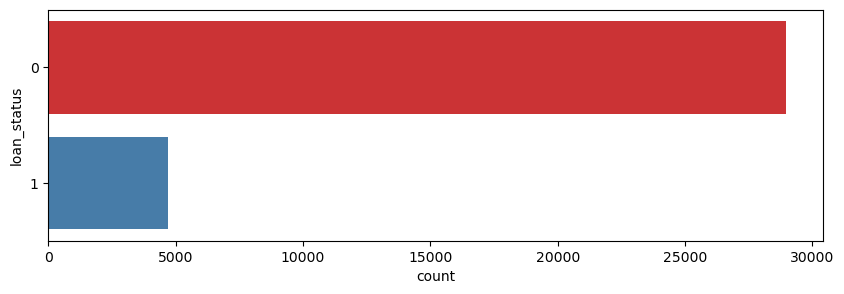

In [96]:
# visualizing the defaulters
# Inference : Approx 17% are defaulters

plt.figure(figsize=(10,3))
sns.countplot(y="loan_status", data=loan_data, palette = 'Set1')
plt.show()

#### Univariate Analysis

In [98]:
# creating function to plot countplot using default status 0 to 1

def plotUnivariate(x, figsize=(10,5)):
    color = (0.2, # red
         0.4, # green
         0.2, # blue
         0.6 # transparency
         )
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y='loan_status', data=loan_data, color=color)
    plt.title("Loan Defaulters against "+str(x))
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()

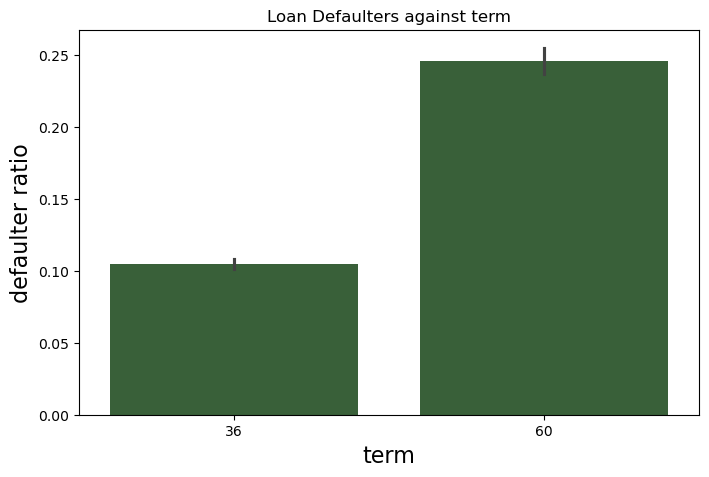

In [100]:
#  defulters against term using countplot
# Inference : defaulters rate is increasing with term   (driving parameter)

plotUnivariate("term", figsize=(8,5))

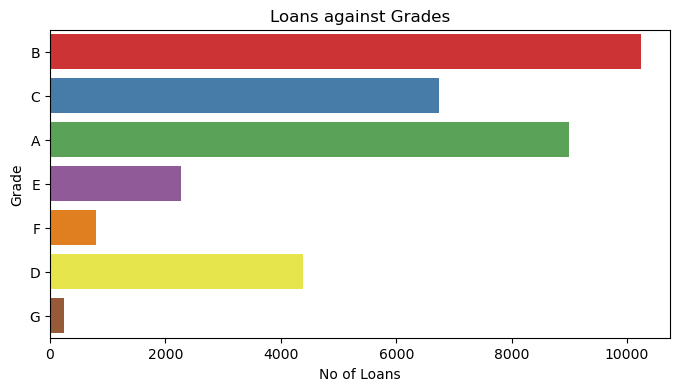

In [102]:
# loans against grade using countplot
# Inference : Large amount of loans are with higher grades  (driving parameter)

plt.figure(figsize=(8,4))
sns.countplot(loan_data.grade, palette = 'Set1')
plt.ylabel('Grade')
plt.xlabel('No of Loans')
plt.title('Loans against Grades')
plt.show()

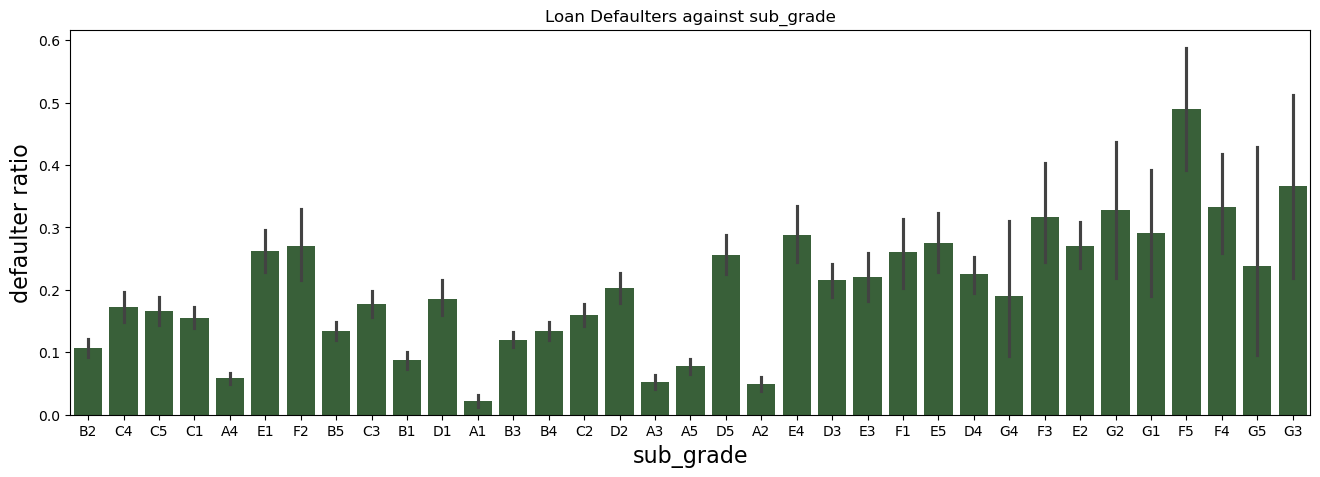

In [104]:
# defaulters against sub_grade using countplot
# Inference : defaulters rate is increasing with sub_grade - A1 through to G5   (driving parameter)

plotUnivariate("sub_grade", figsize=(16,5))

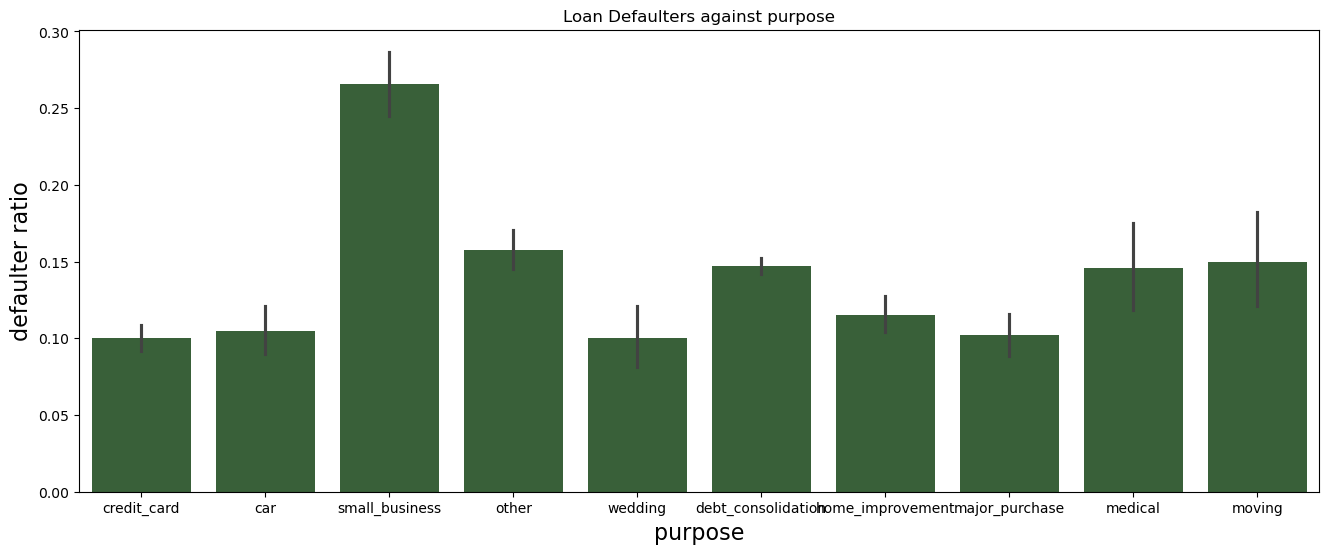

In [106]:
# defaulters against purpose using countplot
# Inference : defaulters rate is depending on purpose of the loan and small business has highest number (driving parameter)

plotUnivariate("purpose", figsize=(16,6))

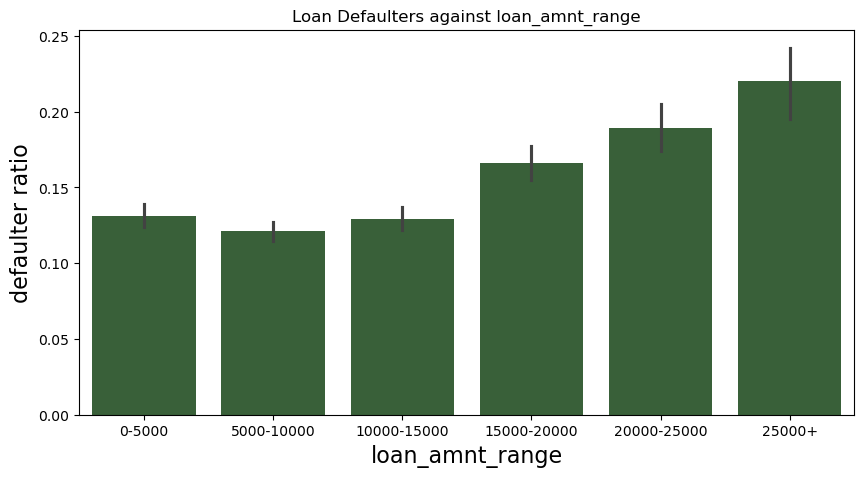

In [108]:
# defaulters against loan amount using countplot
# Inference : defaulters rate is increaing with loan amount range (driving parameter)

plotUnivariate("loan_amnt_range")

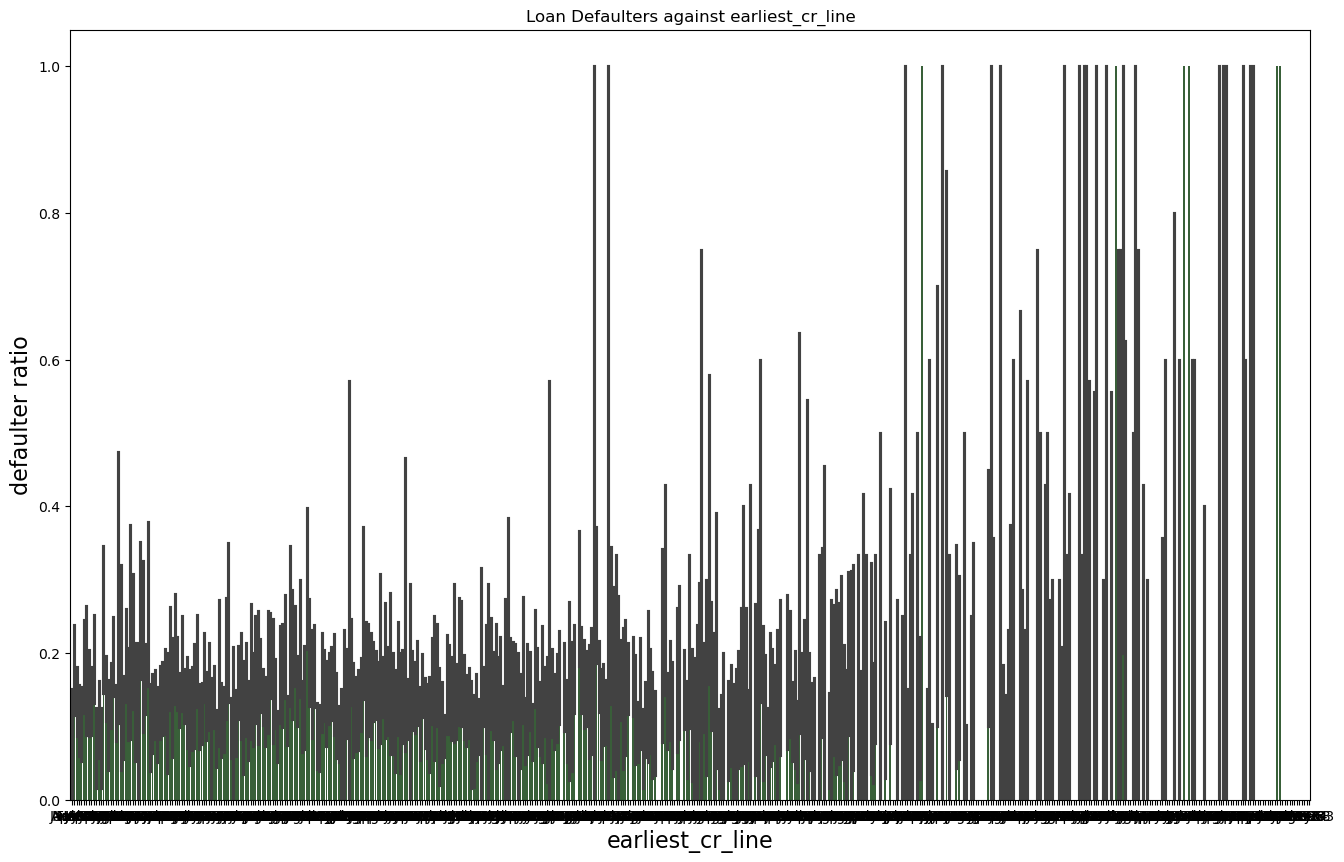

In [110]:
# defaulters against earliest credit line using countplot
# Inference : defaulters rate is inconsistent with earliest credit line (not a driving parameter)

plotUnivariate("earliest_cr_line", figsize=(16,10))

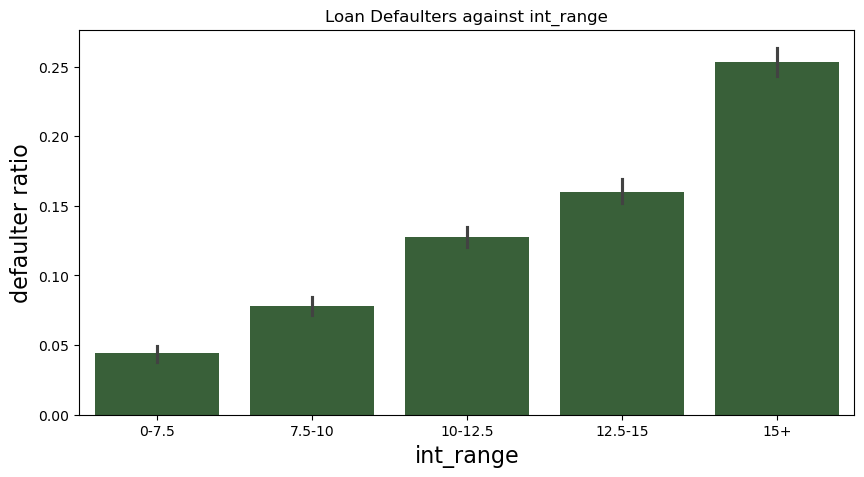

In [112]:
# defaulters against interest range using countplot
# Inference : defaulters rate is decreasing with interest range (driving parameter)

plotUnivariate("int_range")

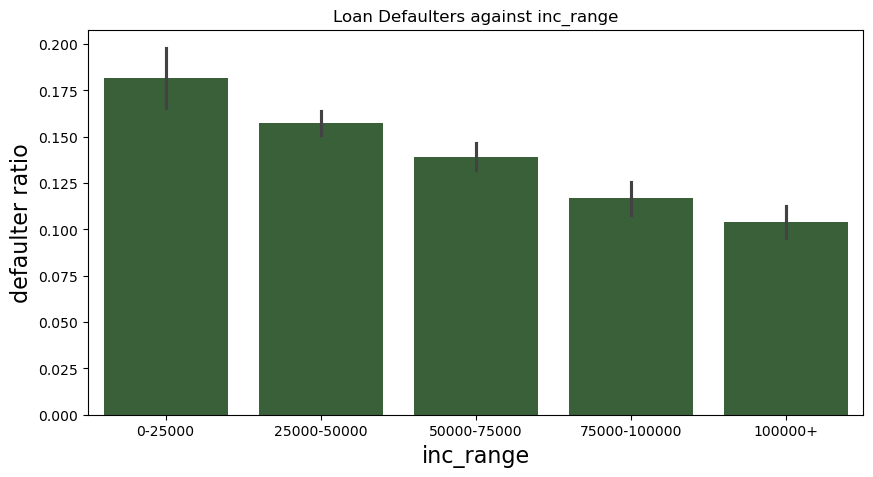

In [114]:
# defaulters against annual income range using countplot
# Inference : defaulters rate is decreasing with annual income range (driving parameter)

plotUnivariate("inc_range")

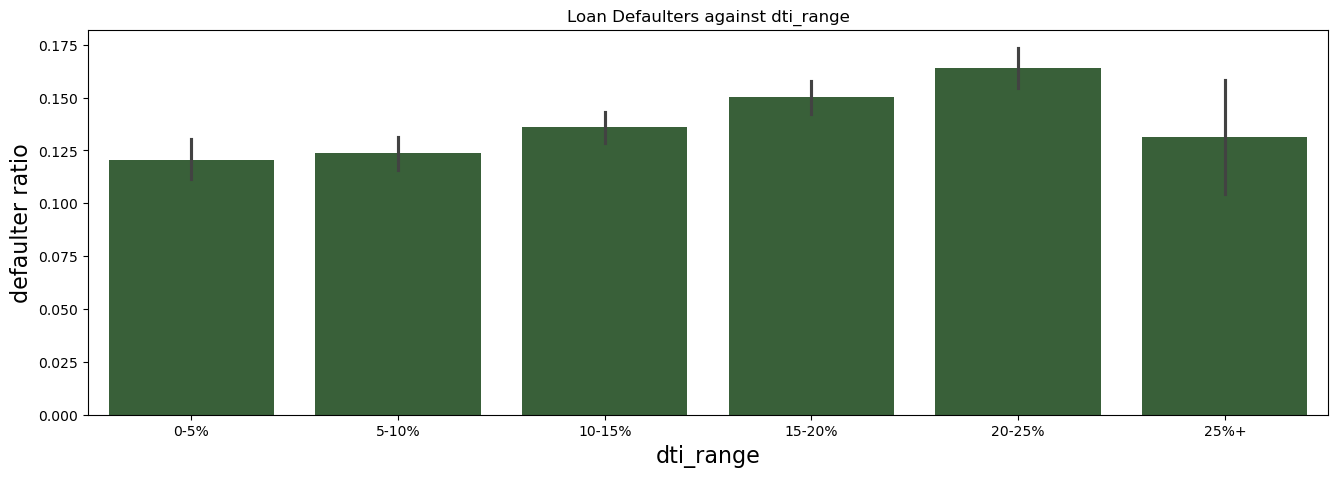

In [116]:
# defaulters against DTI range using countplot
# Inference : defaulters rate is increasing witn DTI values (driving parameter)

plotUnivariate("dti_range", figsize=(16,5))

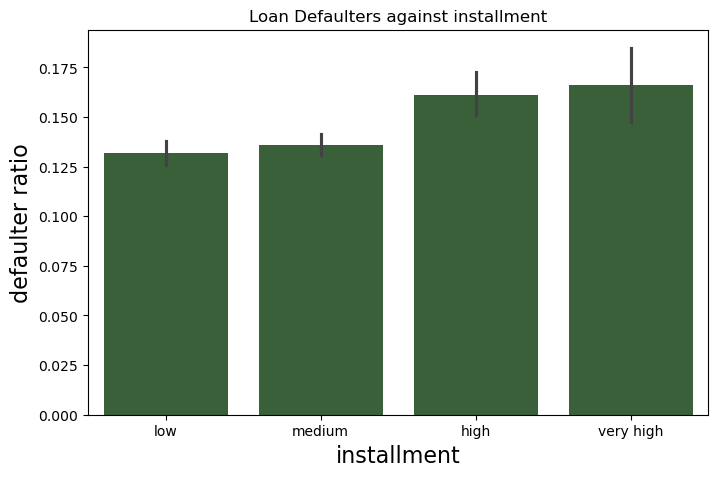

In [118]:
# defaulters against installments using countplot
# Inference : defaulters rate is increasing witn installment values (driving parameter)

plotUnivariate("installment", figsize=(8,5))

##### Univariate Analysis Summary

From our Univariate analysis, we have logically arrived at the parameters to be looled at while deciding which customers are likely to default  -  term, grade, purpose, pub_rec, revol_util, funded_amnt_inv, int_rate,annual_inc, dti, installment

#### Bivariate Analysis

In [165]:
# defining function to plot scatter plot involving 2 variables

def plot_Scatter(x, y):
    plt.figure(figsize=(16,6))
    sns.scatterplot(x=x, y=y, hue="loan_status", data=loan_data)
    plt.title("Scatter plot between "+x+" and "+y)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
plt.show()

In [122]:
# defining function to plot bar plot involving 2 variables

def plot_Bivariate(x, hue, figsize=(16,6)):
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y='loan_status', hue=hue, data=loan_data)
    plt.title("Loan Default ratio against "+x+" for "+hue)
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()

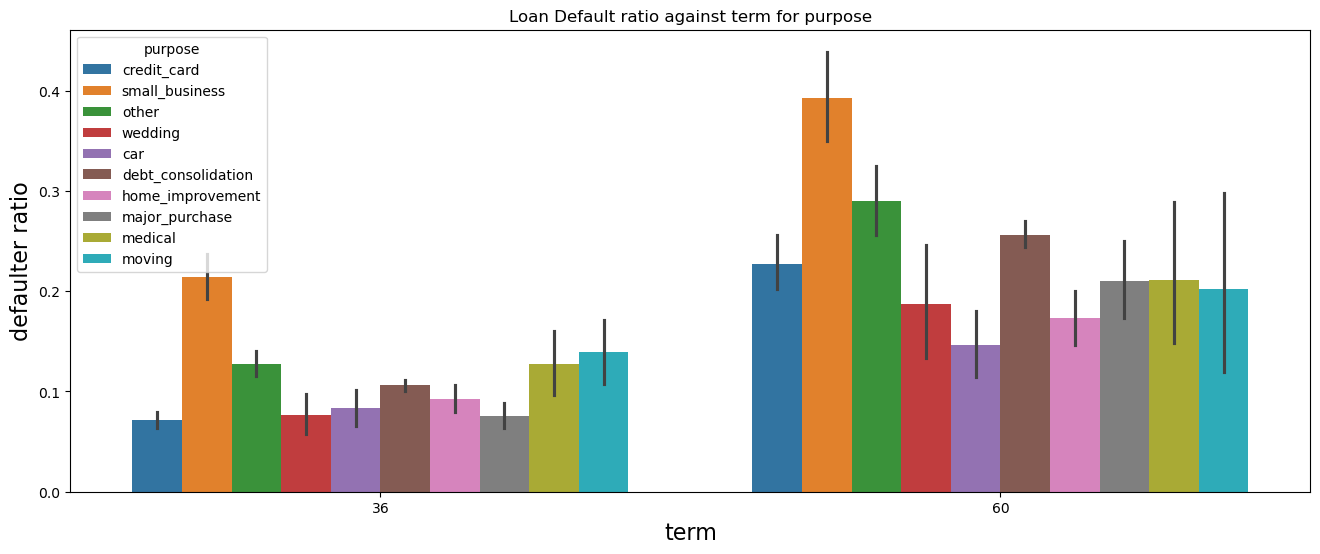

In [124]:
# defaulters against term and purpose using countplot
# Inference : defaulter ratio show strong correlation - default ratio increases against term for purpose (relationship exists)

plot_Bivariate("term", "purpose")

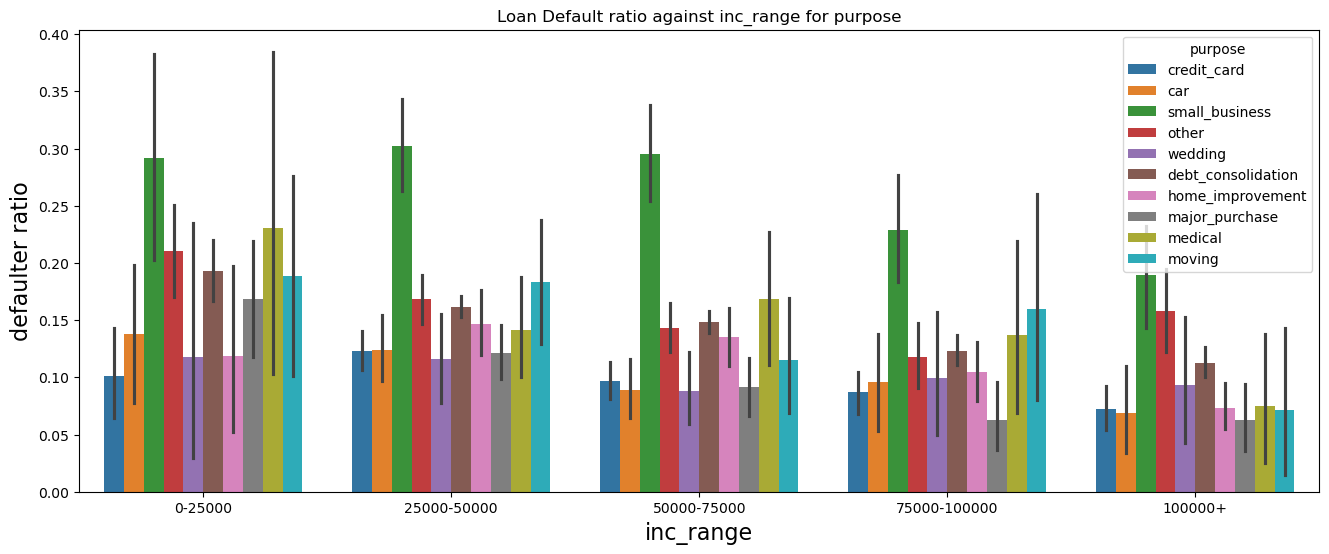

In [126]:
# defaulters against annual income and purpose using countplot
# Inference : defaulter ratio does not show correlation against income for purpose (no relationship exists)

plot_Bivariate("inc_range", "purpose")

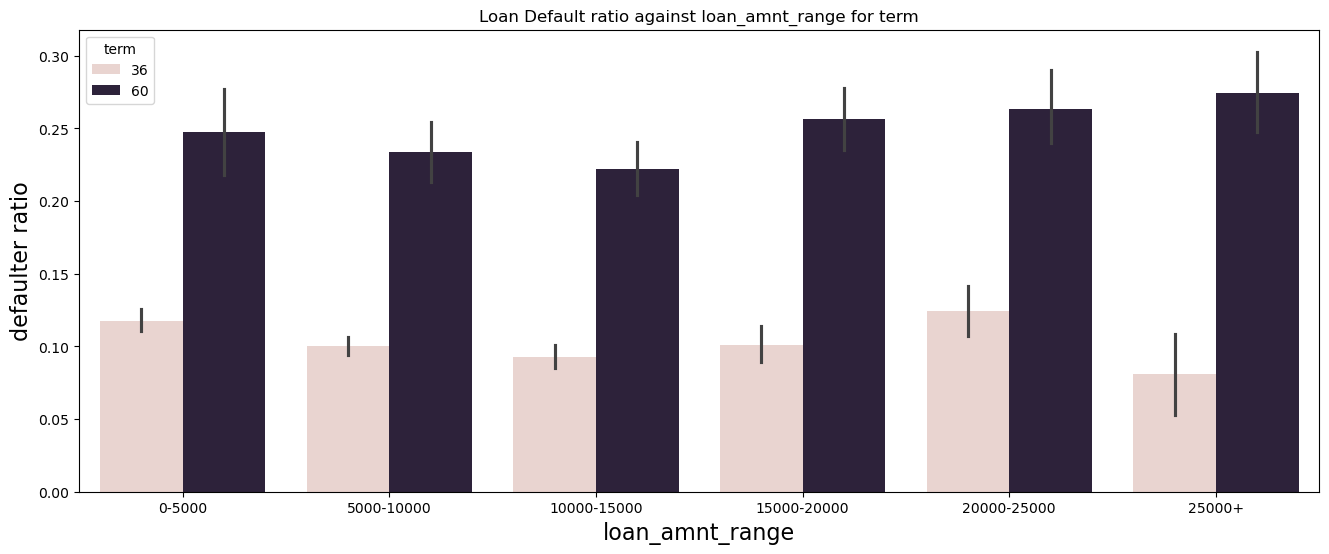

In [128]:
# defaulters against loan amount range and term using countplot
# Inference : defaulter ratio increases for each term for loan amount (relationship exists)

plot_Bivariate("loan_amnt_range", "term")

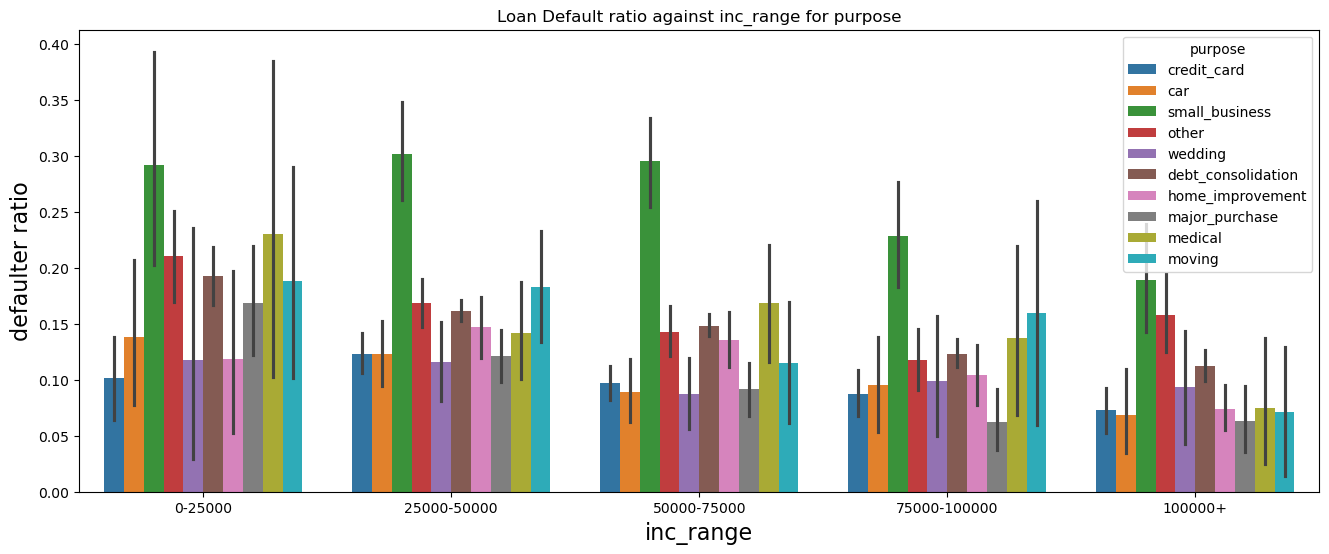

In [130]:
# defaulters against annual income and purpose using countplot 
# Inference : defaulter ratio is increasing for each purpose against income range (relationship exists)

plot_Bivariate("inc_range", "purpose")

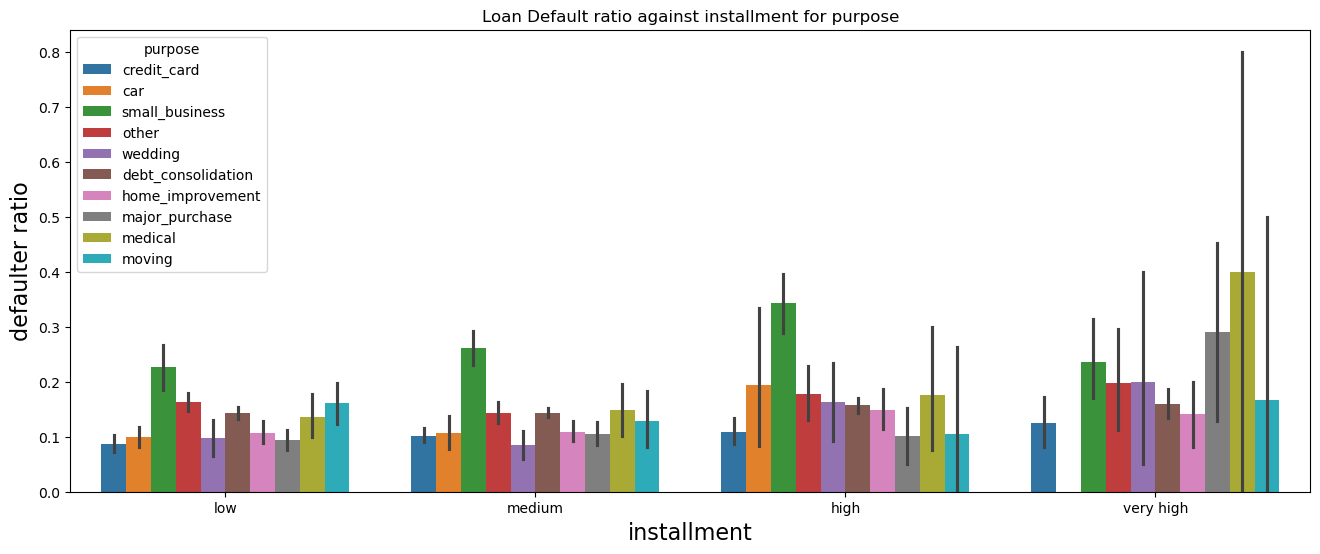

In [132]:
# defaulters against installments and purpose using countplot 
# Inference : defaulter ratio is increasing for each purpose against installment except small business (relationship exists)

plot_Bivariate("installment", "purpose")

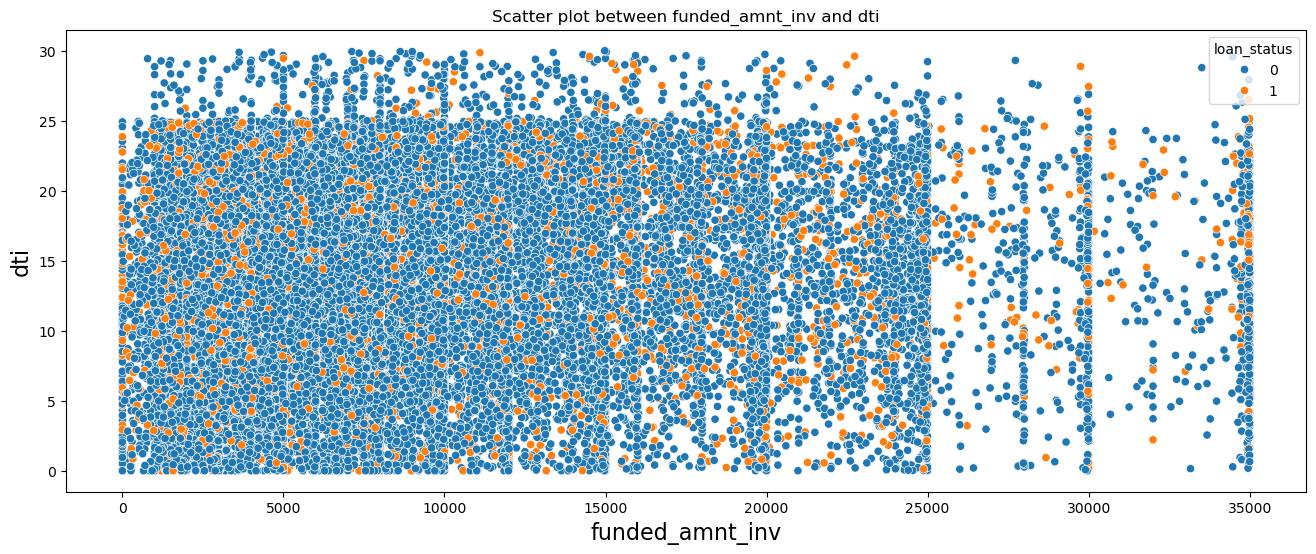

In [158]:
# Plotting for amount funded by investors with DTI using scatterplot
# Inference : There is no relationship as can be seen from the straight lines in the plot (no relationship exists)

plot_Scatter("funded_amnt_inv","dti")

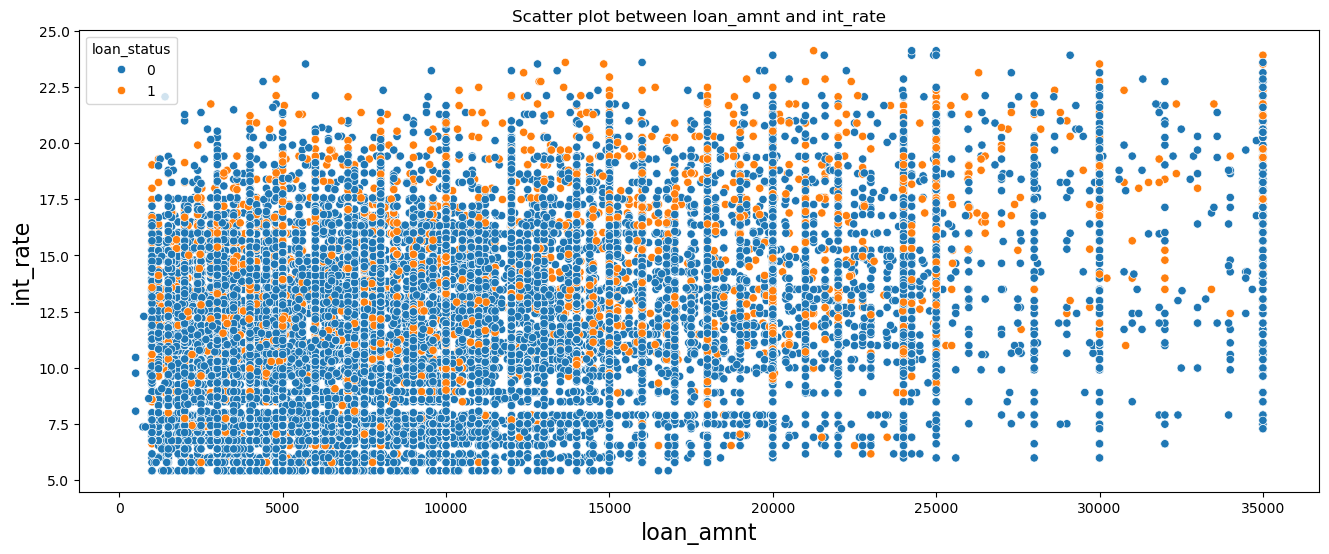

In [160]:
# Plotting for loan amoount with interest rate using scatterplot
# Inference : There is no relationship as can be seen from the straight lines in the plot (no relationship exists)

plot_Scatter("loan_amnt","int_rate")

In [154]:
loan_data.annual_inc

0        24000.00
1        30000.00
2        12252.00
3        49200.00
5        36000.00
           ...   
39712   110000.00
39713    18000.00
39714   100000.00
39715   200000.00
39716    22000.00
Name: annual_inc, Length: 33671, dtype: float64

In [169]:
# defining unction to plot boxplot for comparing two variables
def plot_Box(x, y, hue="loan_status"):
    plt.figure(figsize=(16,6))
    sns.boxplot(x=x, y=y, data=loan_data, hue=hue, order=sorted(loan_data[x].unique()))
    plt.title("Box plot between "+x+" and "+y+" for "+hue)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()

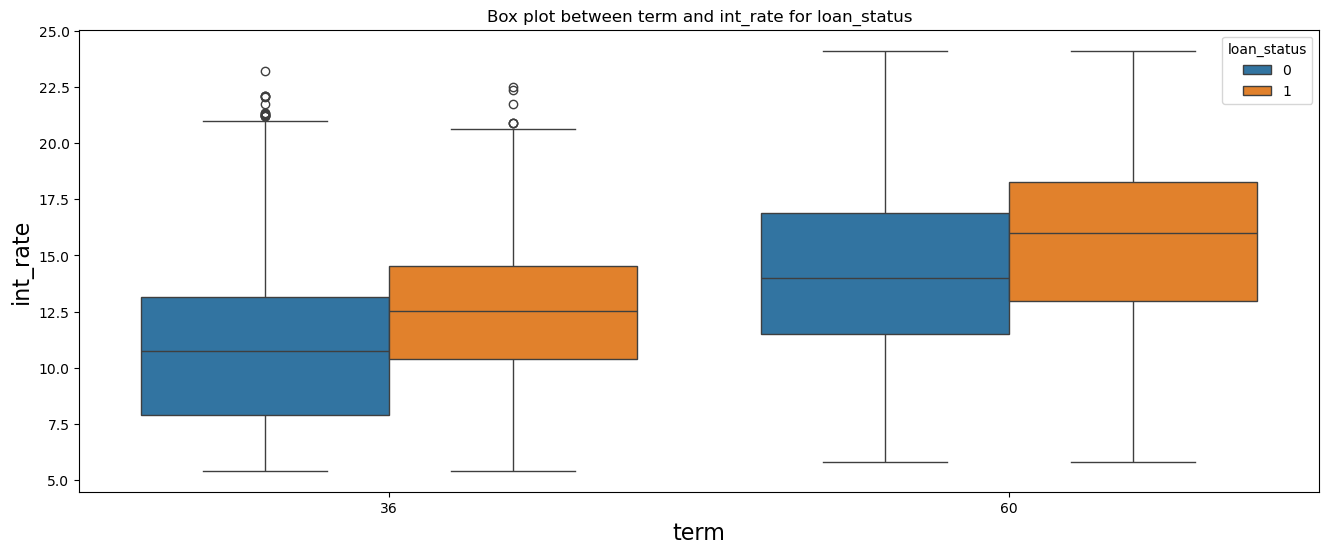

In [171]:
# Plotting  term vs interest rate for each loan_status using box plot
# Inference : Interest rate increased with loan term and this increases the chances of defaulting

plot_Box("term", "int_rate")

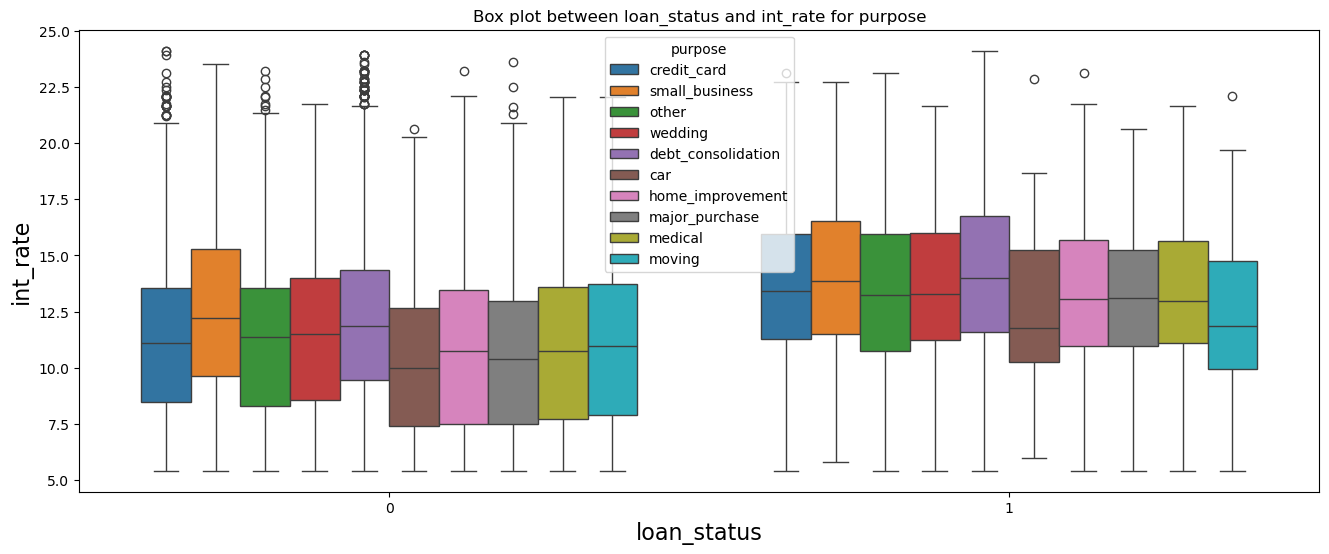

In [173]:
# Plotting loan status vs interes rate for all purpose using box plot
# Inference : Interest rate is high for defaulting cases for all the purpose

plot_Box("loan_status", "int_rate", hue="purpose")

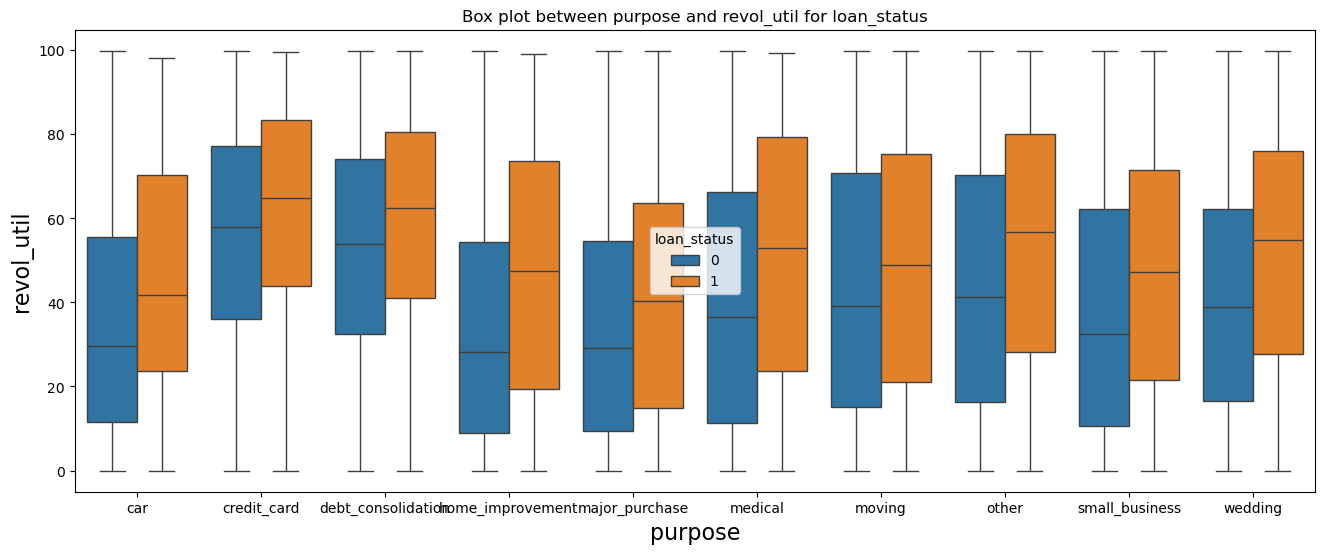

In [175]:
# Plotting purpose vs revo_util for each loan status
# Inference : revol_util is more for all purpose value when the loan is defaulted and is very high for credit_card

plot_Box("purpose", "revol_util")

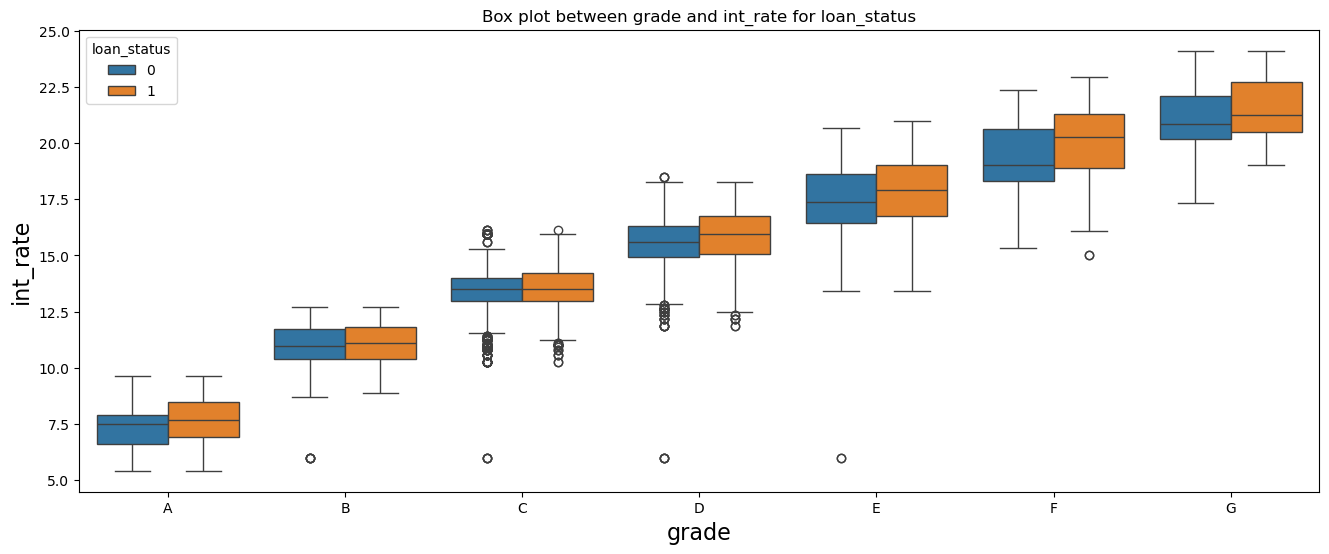

In [177]:
# Plotting grade vs interest rate for each loan status
# Inference : 1) int_rate increasing with grades 
#             2) some of the defaulters are having their median somewhat near to 75% quantile of int_rate of those fully paid

plot_Box("grade", "int_rate", "loan_status")

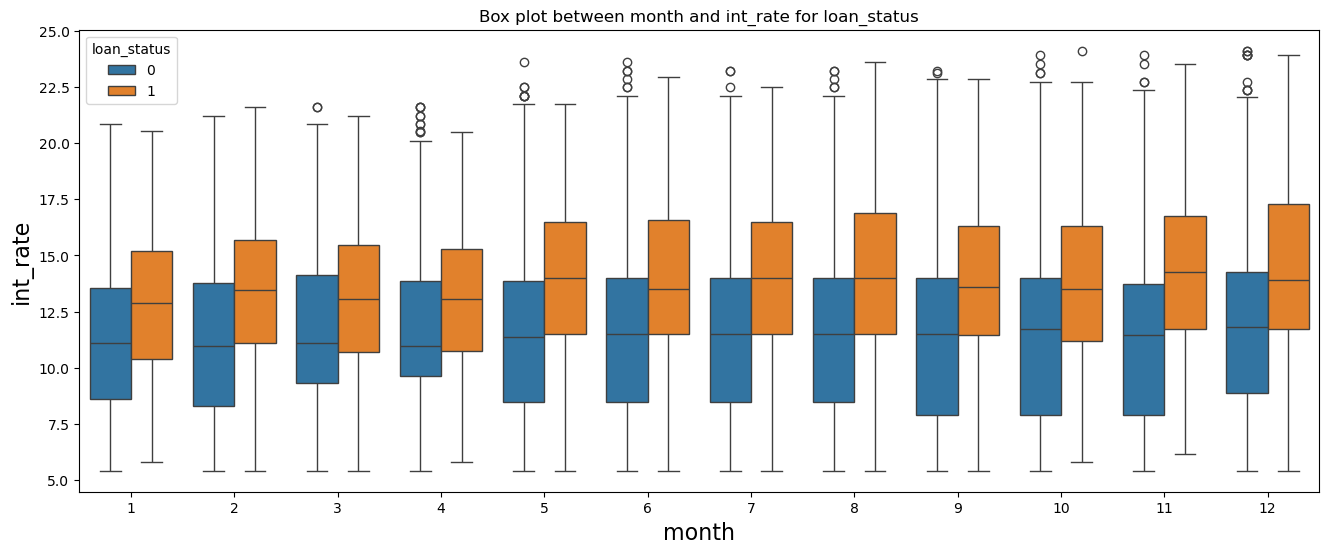

In [179]:
# Plotting issue month vs interest rate for each loan status
# Inference : 1) int_rate for defaulters constantly increasing over month
#             2) Defaulters median near to 75% quantile of int_rate of those fully paid. But it is constant every month & not very useful

plot_Box("month", "int_rate", "loan_status")

##### BiVariate Analysis Summary

From our Bivariate analysis, we have logically arrived at the parameters to be looled at while deciding which customers are likely to default -  term, grade, purpose, pub_rec, revol_util, funded_amnt_inv, int_rate, annual_inc, installment

#### Multivariate Analysis

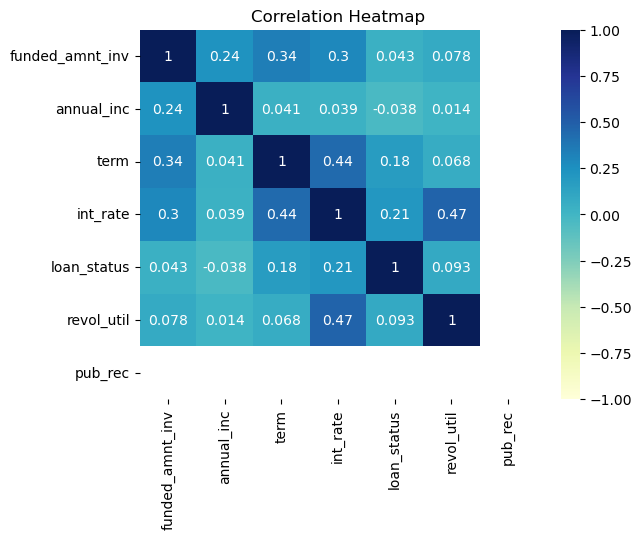

In [184]:
# Plotting heatmap to see if there is correlation among variables 

continuous_var = ["funded_amnt_inv", "annual_inc", "term", "int_rate", "loan_status", "revol_util", "pub_rec"]
loan_corrl = loan_data[continuous_var].corr()
sns.heatmap(loan_corrl,vmin=-1.0,vmax=1.0,annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

##### MultiVariate Analysis Summary

From our MuktiVvariate analysis, we have logically arrived at the parameters to be looled at while deciding which customers are likely to default -  term, grade, purpose, revol_util, int_rate, installment, annual_inc,funded_amnt_inv


### Conclusion & Recommendations

In [ ]:
# After analysing all the relevant & related parameters available in the dataset, we have come to an informed
# opinion on driving parameters, which can help the company in deciding whether a loan is to be sanctioned  
# or denied to the customer.
# The best driving parameters are - term, grade, purpose, revol_util, int_rate, installment, annual_inc, funded_amnt_inv